# Visualization

## Init

In [1]:
from pathlib import Path

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    auc,
)

In [3]:
from model import Model
from dataset import create_df_from_dataset
from training import evaluate, batchify

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


## Load data from training

In [5]:
training_path = Path(".")

In [6]:
model_path = training_path / "model_checkpoint.pt"
model_path.exists()

True

In [7]:
results_path = training_path / "res.tar"
results_path.exists()

True

In [8]:
figspath = training_path / "fig"
figspath.mkdir(exist_ok=True)

In [9]:
res_dict = torch.load(results_path, weights_only=False, map_location=device)
res_dict

{'accuracies': array([0.53571429, 0.46428571, 0.69642857, 0.67857143, 0.78571429]),
 'f1s': array([0.69767442, 0.        , 0.76056338, 0.75675676, 0.81818182]),
 'losses': array([6.53139442, 6.10795814, 5.75958601, 5.72330242, 5.28324813]),
 'num_frames': 120,
 'sample_rate': 16000,
 'num_hidden_layers': 6,
 'num_attention_heads': 3,
 'intermediate_size': 300,
 'epochs': 5,
 'seed': 42,
 'test_size': 0.15,
 'val_size': 0.15}

In [10]:
epochs = np.arange(res_dict["epochs"])
epochs

array([0, 1, 2, 3, 4])

## Recreate original dataset

In [11]:
dataset = Dataset.from_pandas(create_df_from_dataset()).take(10)  # Take a subset of N datapoints for testing purposes
dataset = dataset.train_test_split(
    test_size=res_dict["test_size"], seed=res_dict["seed"], shuffle=True
)
train_dataset = dataset["train"]
train_dataset = train_dataset.train_test_split(
    test_size=(res_dict["val_size"] / (1 - res_dict["test_size"])),
    seed=res_dict["seed"],
    shuffle=True,
)
val_dataset = train_dataset["test"]
train_dataset = train_dataset["train"]
test_dataset = dataset["test"]

## Training results

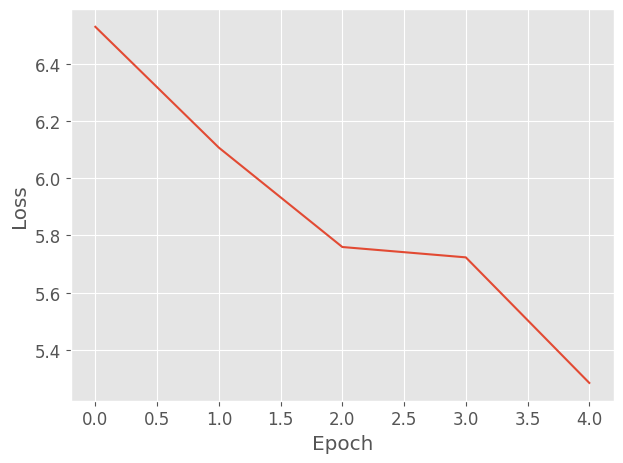

In [12]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    ax.plot(epochs, res_dict["losses"])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    fig.tight_layout()
    figpath = figspath / "loss.png"
    fig.savefig(fname=figpath)
    plt.show()

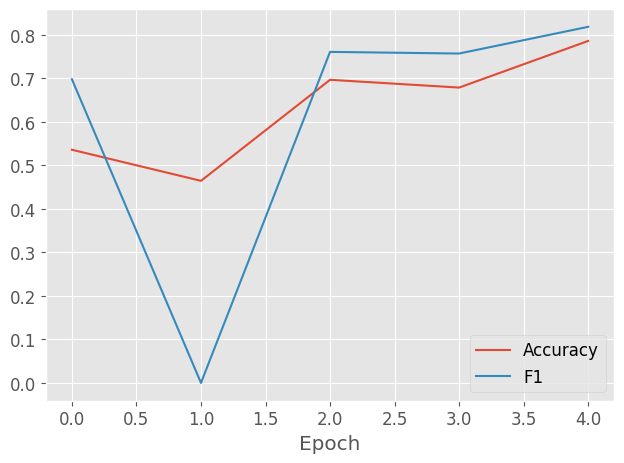

In [13]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    ax.plot(epochs, res_dict["accuracies"], label="Accuracy")
    ax.plot(epochs, res_dict["f1s"], label="F1")
    ax.set_xlabel("Epoch")
    ax.legend(loc="lower right")
    # ax.legend(loc="best")
    fig.tight_layout()
    figpath = figspath / "accu_f1.png"
    fig.savefig(fname=figpath)
    plt.show()

## Model prediction on unseen data

In [14]:
model_state_dict = torch.load(model_path, weights_only=False, map_location=device)

In [15]:
model = Model(
    num_frames=res_dict["num_frames"],
    sample_rate=res_dict["sample_rate"],
    num_hidden_layers=res_dict["num_hidden_layers"],
    num_attention_heads=res_dict["num_attention_heads"],
    intermediate_size=res_dict["intermediate_size"],
)

/home/kir0ul/Projects/COMP.5530_DL-project/.direnv/python-3.13.9/lib64/python3.13/site-packages/transformers/audio_utils.py:525: UserWarning: At least one mel filter has all zero values. The value for `num_mel_filters` (128) may be set too high. Or, the value for `num_frequency_bins` (257) may be set too low.
  warnings.warn(


In [16]:
model.load_state_dict(state_dict=model_state_dict)

<All keys matched successfully>

In [17]:
# evaluate(model=model, data=test_dataset, sample_rate=res_dict["sample_rate"])
# # evaluate(model=model, data=val_dataset, sample_rate=res_dict["sample_rate"])
# # evaluate(model=model, data=train_dataset, sample_rate=res_dict["sample_rate"])

In [18]:
data = test_dataset
data

Dataset({
    features: ['video', 'audio', 'label'],
    num_rows: 2
})

In [19]:
model.eval()
videos, audios = batchify(batch=data, sample_rate=res_dict["sample_rate"])
y_score = torch.sigmoid(model(videos, audios)).squeeze(-1).detach().numpy()
y_pred = np.round(y_score)
# y_pred = torch.round(torch.sigmoid(model(videos, audios)).squeeze(-1)).detach().numpy()
y_true = np.array(data["label"])

In [20]:
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
f1 = f1_score(y_true=y_true, y_pred=y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

Accuracy: 0.5
F1: 0.6666666666666666


## Confusion matrix

In [21]:
# confusion matrix
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_matrix

array([[0, 1],
       [0, 1]])

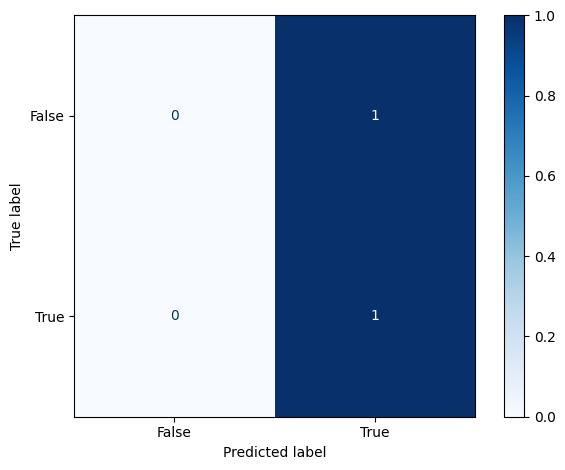

In [35]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_true,
    y_pred=y_pred,
    cmap=plt.cm.Blues,
    # text_kw={"fontsize": 12}
)
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=conf_matrix,
#     cmap=plt.cm.Blues,
# )  # , display_labels=conf_mat_labels)
# disp.plot()
# for labels in disp.text_.ravel():
#     labels.set_fontsize(12)  # Sets the font size to 30
plt.tight_layout()
figpath = figspath / "confusion_matrix.png"
plt.savefig(fname=figpath)
plt.show()

## AUC ROC

In [36]:
# AUC ROC
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
roc_auc = roc_auc_score(y_true=y_true, y_score=y_score)

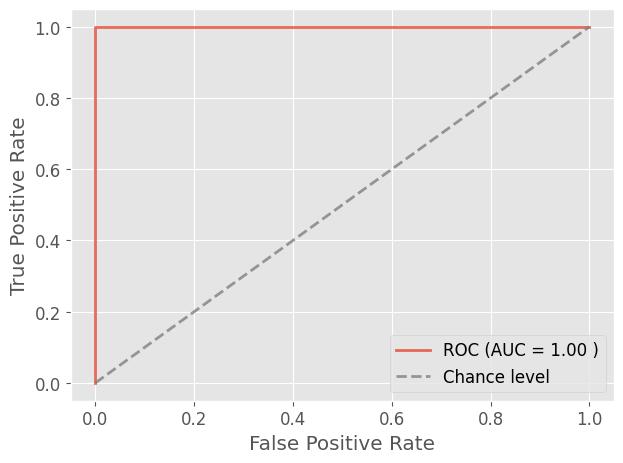

In [37]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    ax.plot(
        fpr,
        tpr,
        label=f"ROC (AUC = {roc_auc:0.2f} )",
        lw=2,
        alpha=0.8,
    )
    ax.plot(
        np.array([0, 1]),
        np.array([0, 1]),
        label="Chance level",
        lw=2,
        color="grey",
        linestyle="dashed",
        alpha=0.8,
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        # title="ROC curve",
    )
    # ax.legend(loc="lower right")
    ax.legend(loc="best")
    fig.tight_layout()
    figpath = figspath / "AUC_ROC.png"
    fig.savefig(fname=figpath)
    plt.show()